Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Shape: (3685, 14)
Columns: ['title', 'price', 'mileage_miles', 'registration_year', 'previous_owners', 'fuel_type', 'body_type', 'Gearbox', 'Doors', 'Seats', 'emission_class', 'service_history', 'engine_l', 'brand']
            title  price  mileage_miles  registration_year  previous_owners  \
0     SKODA Fabia   6900          70189               2016              3.0   
1  Vauxhall Corsa   1495          88585               2008              4.0   
2     Hyundai i30    949         137000               2011              NaN   

  fuel_type  body_type Gearbox  Doors  Seats emission_class service_history  \
0    Diesel  Hatchback  Manual    5.0    5.0         Euro 6             NaN   
1    Petrol  Hatchback  Manual    3.0    5.0         Euro 4            Full   
2    Petrol  Hatchback  Manual    5.0    5.0         Euro 5             NaN   

   engine_l     brand

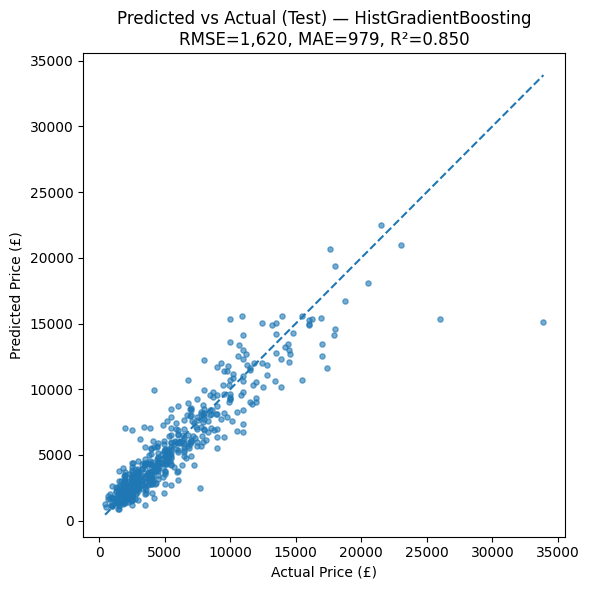

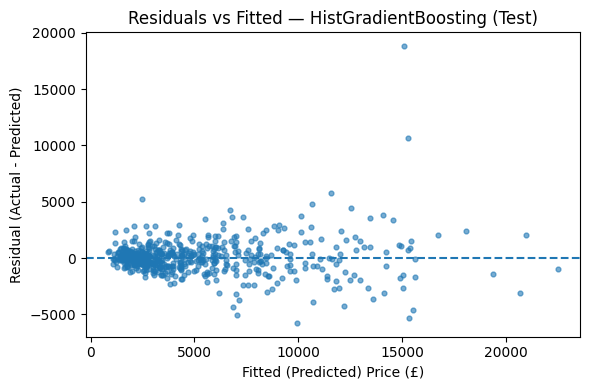

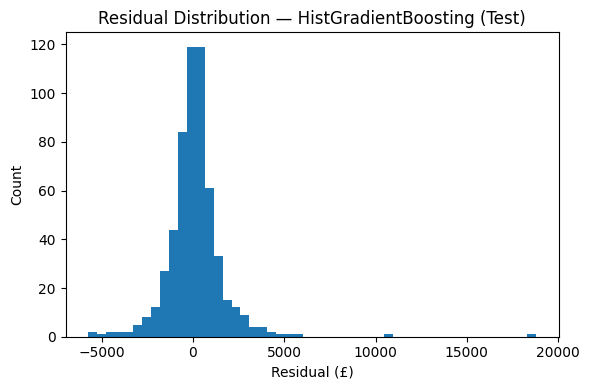

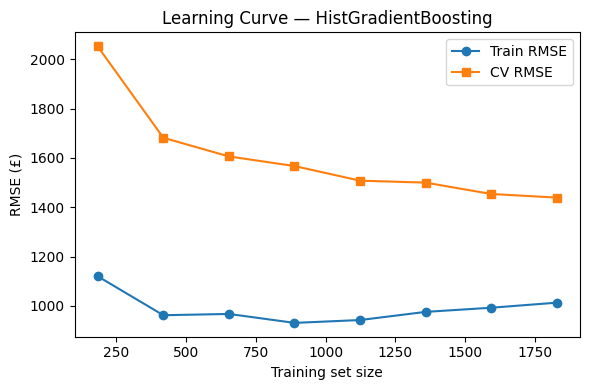

Computing permutation importance on transformed features (top 20)...


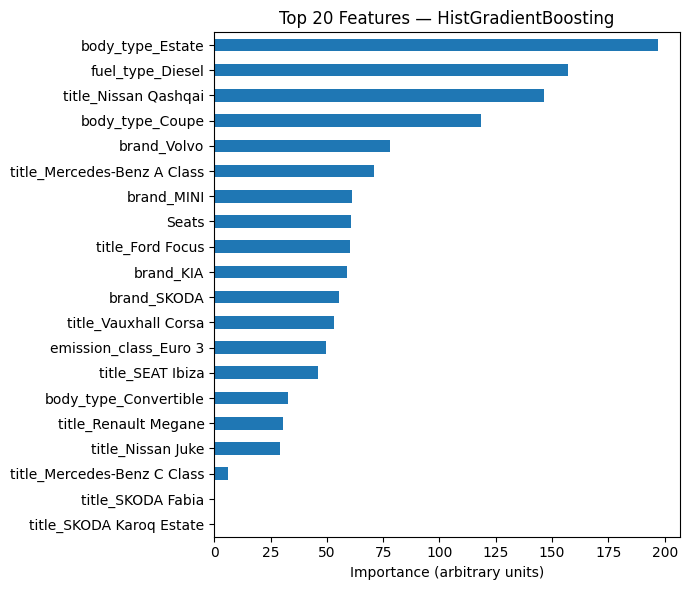


All figures saved to: /content/drive/MyDrive/ai/used_car_study/figures
Study artifacts:
 - Final model: /content/drive/MyDrive/ai/used_car_study/best_model.joblib
 - Metrics CSV: /content/drive/MyDrive/ai/used_car_study/model_metrics.csv
 - Figures dir: /content/drive/MyDrive/ai/used_car_study/figures

Example input row:
                       title  mileage_miles  registration_year  \
2397  Suzuki Swift Hatchback          64156               2015   

      previous_owners fuel_type  body_type Gearbox  Doors  Seats  \
2397              1.0    Petrol  Hatchback  Manual    5.0    5.0   

     emission_class service_history  engine_l   brand  
2397         Euro 5             NaN       1.2  Suzuki  
Predicted price: £5,026
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 78.3 MB/s eta 0:00:00

Report saved to: /content/drive/MyDrive/ai/used_car_study/used_car_price_report.docx


In [ ]:
# ===========================
# Used Car Price Prediction (UK)
# Journal-ready pipeline: cleaning + CV model selection + figures + Word report
# ===========================

# 0) Setup: mount Drive and set paths
from google.colab import drive
drive.mount('/content/drive')

CSV_PATH = "/content/drive/MyDrive/ai/Used Cars Prices in UK export 2025-08-09 05-54-05.csv"
OUTPUT_DIR = "/content/drive/MyDrive/ai/used_car_study"
MODEL_OUT = f"{OUTPUT_DIR}/best_model.joblib"
METRICS_OUT = f"{OUTPUT_DIR}/model_metrics.csv"
FIG_DIR = f"{OUTPUT_DIR}/figures"

# Create directories
import os, warnings
warnings.filterwarnings("ignore")
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

# 1) Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, learning_curve, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.compose import TransformedTargetRegressor
from sklearn.base import clone
from sklearn.inspection import permutation_importance
import joblib
rng = np.random.RandomState(42)

# Optional: XGBoost if available
try:
    from xgboost import XGBRegressor
    HAVE_XGB = True
except Exception:
    HAVE_XGB = False

# --- Helpers ---
def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))  # version-safe

def savefig(path):
    plt.tight_layout()
    plt.savefig(path, dpi=300, bbox_inches="tight")
    plt.show()

# 2) Load data
df = pd.read_csv(CSV_PATH)

# === LIGHT CLEANING & NORMALIZATION ===
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

df = df.rename(columns={
    "Price": "price",
    "Mileage(miles)": "mileage_miles",
    "Registration_Year": "registration_year",
    "Previous Owners": "previous_owners",
    "Fuel type": "fuel_type",
    "Body type": "body_type",
    "Emission Class": "emission_class",
    "Service history": "service_history"
})

def parse_engine(val):
    if pd.isna(val):
        return np.nan
    s = str(val).strip().lower().replace("litre", "l").replace("liter", "l")
    try:
        if "l" in s:
            s = s.split("l")[0]
        return float(s)
    except:
        return np.nan

if "Engine" in df.columns:
    df["engine_l"] = df["Engine"].apply(parse_engine)
    df = df.drop(columns=["Engine"])

def get_brand(title):
    if pd.isna(title):
        return np.nan
    return str(title).strip().split()[0]

if "title" in df.columns:
    df["brand"] = df["title"].apply(get_brand)

for col in ["price", "mileage_miles", "registration_year", "previous_owners", "Doors", "Seats"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print(df.head(3))

# 3) Target
TARGET = "price"
assert TARGET in df.columns, f"TARGET '{TARGET}' not found. Available: {df.columns.tolist()}"

# 4) Basic cleaning
df = df.drop_duplicates()

# 5) Features/Target split
X = df.drop(columns=[TARGET])
y = df[TARGET].astype(float)

# 6) Identify column types automatically
numeric_features = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
categorical_features = [c for c in X.columns if c not in numeric_features]

print("\nNumeric features:", numeric_features)
print("Categorical features:", categorical_features)

# 7) Preprocessing (version-safe OneHotEncoder)
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
])

categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", ohe)
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, numeric_features),
        ("cat", categorical_pipeline, categorical_features),
    ],
    remainder="drop"
)

# 8) Splits (60/20/20 overall)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, random_state=42
)
print(f"\nShapes -> Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# 9) Define models + search spaces
cv = KFold(n_splits=5, shuffle=True, random_state=42)

def ttr(est):
    # Log1p target transform for skewed prices
    return TransformedTargetRegressor(regressor=est, func=np.log1p, inverse_func=np.expm1)

candidates = {
    "LinearRegression": {
        "estimator": LinearRegression(),
        "param_distributions": {}  # no params
    },
    "Ridge": {
        "estimator": Ridge(random_state=42) if "random_state" in Ridge().get_params() else Ridge(),
        "param_distributions": {"alpha": np.logspace(-3, 3, 50)}
    },
    "Lasso": {
        "estimator": Lasso(max_iter=10000, random_state=42) if "random_state" in Lasso().get_params() else Lasso(max_iter=10000),
        "param_distributions": {"alpha": np.logspace(-4, 1, 60)}
    },
    "ElasticNet": {
        "estimator": ElasticNet(max_iter=10000, random_state=42) if "random_state" in ElasticNet().get_params() else ElasticNet(max_iter=10000),
        "param_distributions": {
            "alpha": np.logspace(-4, 1, 40),
            "l1_ratio": np.linspace(0.05, 0.95, 19)
        }
    },
    "RandomForest": {
        "estimator": RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=42),
        "param_distributions": {
            "n_estimators": [400, 600, 800],
            "max_depth": [None, 10, 20, 30],
            "min_samples_split": [2, 4, 8],
            "min_samples_leaf": [1, 2, 4]
        }
    },
    "HistGradientBoosting": {
        "estimator": HistGradientBoostingRegressor(random_state=42),
        "param_distributions": {
            "learning_rate": np.logspace(-2, -0.1, 10),
            "max_depth": [None, 6, 8, 10],
            "l2_regularization": np.logspace(-3, 1, 10),
            "max_bins": [64, 128, 255]
        }
    },
    "SVR": {
        "estimator": SVR(kernel="rbf"),
        "param_distributions": {
            "C": np.logspace(-1, 3, 12),
            "gamma": np.logspace(-4, -1, 8),
            "epsilon": np.logspace(-3, 0, 8)
        }
    }
}

if HAVE_XGB:
    candidates["XGBRegressor"] = {
        "estimator": XGBRegressor(
            n_estimators=800, learning_rate=0.05, subsample=0.8, colsample_bytree=0.9,
            reg_lambda=1.0, random_state=42, tree_method="hist", n_jobs=-1
        ),
        "param_distributions": {
            "max_depth": [4, 6, 8, 10],
            "min_child_weight": [1, 3, 5, 7],
            "reg_alpha": [0.0, 0.1, 0.5, 1.0]
        }
    }

# 10) Search each model on TRAIN (5-fold CV), evaluate on VAL
results = []
best_pipes = {}

for name, cfg in candidates.items():
    print(f"\n=== Tuning {name} ===")
    base_est = cfg["estimator"]
    param_dist = cfg["param_distributions"]

    pipe = Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", ttr(base_est))
    ])

    if len(param_dist) == 0:
        pipe.fit(X_train, y_train)
        y_val_pred = pipe.predict(X_val)
        res = {
            "model": name,
            "cv_best_rmse": np.nan,  # no search
            "val_rmse": rmse(y_val, y_val_pred),
            "val_mae": mean_absolute_error(y_val, y_val_pred),
            "val_r2": r2_score(y_val, y_val_pred),
            "best_params": {}
        }
        best_pipes[name] = pipe
    else:
        search_space = {f"model__regressor__{k}": v for k, v in param_dist.items()}

        search = RandomizedSearchCV(
            estimator=pipe,
            param_distributions=search_space,
            n_iter=40,
            scoring="neg_mean_squared_error",
            cv=cv,
            random_state=42,
            n_jobs=-1,
            verbose=1
        )
        search.fit(X_train, y_train)
        best_pipe = search.best_estimator_   # <- FIXED (single underscore)
        y_val_pred = best_pipe.predict(X_val)
        res = {
            "model": name,
            "cv_best_rmse": float(np.sqrt(-search.best_score_)),
            "val_rmse": rmse(y_val, y_val_pred),
            "val_mae": mean_absolute_error(y_val, y_val_pred),
            "val_r2": r2_score(y_val, y_val_pred),
            "best_params": search.best_params_
        }
        best_pipes[name] = best_pipe

    print(res)
    results.append(res)

results_df = pd.DataFrame(results).sort_values(by="val_rmse")
print("\nValidation leaderboard (sorted by RMSE):")
print(results_df)

# Save comparison table
results_df.to_csv(METRICS_OUT, index=False)
print(f"\nSaved metrics to: {METRICS_OUT}")

# 11) Choose best by validation RMSE and retrain on TRAIN+VAL
best_name = results_df.iloc[0]["model"]
print(f"\nBest by validation RMSE: {best_name}")

best_pipe_val = best_pipes[best_name]

# Pull out tuned regressor for final fit
best_reg = best_pipe_val.named_steps["model"].regressor
final_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", TransformedTargetRegressor(
        regressor=clone(best_reg),
        func=np.log1p, inverse_func=np.expm1
    ))
])
final_pipe.fit(X_trainval, y_trainval)

# 12) Final test evaluation
y_test_pred = final_pipe.predict(X_test)
test_rmse = rmse(y_test, y_test_pred)
test_mae  = mean_absolute_error(y_test, y_test_pred)
test_r2   = r2_score(y_test, y_test_pred)
print(f"\n[TEST] Final ({best_name}) | RMSE: {test_rmse:,.2f} | MAE: {test_mae:,.2f} | R2: {test_r2:,.4f}")

# Append final test row and resave metrics
final_row = {
    "model": f"FINAL_TEST_{best_name}",
    "cv_best_rmse": np.nan,
    "val_rmse": np.nan,
    "val_mae": np.nan,
    "val_r2": np.nan,
    "best_params": {}
}
results_df = pd.concat([results_df, pd.DataFrame([final_row])], ignore_index=True)
results_df.loc[results_df["model"] == f"FINAL_TEST_{best_name}", ["val_rmse","val_mae","val_r2"]] = [test_rmse, test_mae, test_r2]
results_df.to_csv(METRICS_OUT, index=False)
print(f"Updated metrics (with final test) saved to: {METRICS_OUT}")

# Save final model
joblib.dump(final_pipe, MODEL_OUT)
print(f"Saved final model to: {MODEL_OUT}")

# 13) FIGURES (journal-ready)
def get_feature_names_from_preprocess(preprocess_ct, numeric_cols, categorical_cols):
    names = []
    if "num" in preprocess_ct.named_transformers_:
        names.extend(list(numeric_cols))
    if "cat" in preprocess_ct.named_transformers_:
        ohe_step = preprocess_ct.named_transformers_["cat"].named_steps["onehot"]
        if hasattr(ohe_step, "get_feature_names_out"):
            ohe_names = list(ohe_step.get_feature_names_out(categorical_cols))
        else:
            ohe_names = list(ohe_step.get_feature_names(categorical_cols))
        names.extend(ohe_names)
    return names

feature_names = get_feature_names_from_preprocess(
    final_pipe.named_steps["preprocess"], numeric_features, categorical_features
)

# (a) Predicted vs Actual (test)
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_test_pred, s=14, alpha=0.6)
minp, maxp = np.nanmin([y_test.min(), y_test_pred.min()]), np.nanmax([y_test.max(), y_test_pred.max()])
plt.plot([minp, maxp], [minp, maxp], linestyle="--")
plt.xlabel("Actual Price (£)")
plt.ylabel("Predicted Price (£)")
plt.title(f"Predicted vs Actual (Test) — {best_name}\nRMSE={test_rmse:,.0f}, MAE={test_mae:,.0f}, R²={test_r2:.3f}")
savefig(f"{FIG_DIR}/pred_vs_actual_test_{best_name}.png")

# (b) Residuals vs Fitted (test)
residuals = y_test - y_test_pred
plt.figure(figsize=(6,4))
plt.scatter(y_test_pred, residuals, s=12, alpha=0.6)
plt.axhline(0, linestyle="--")
plt.xlabel("Fitted (Predicted) Price (£)")
plt.ylabel("Residual (Actual - Predicted)")
plt.title(f"Residuals vs Fitted — {best_name} (Test)")
savefig(f"{FIG_DIR}/residuals_vs_fitted_{best_name}.png")

# (c) Residual distribution (test)
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=50)
plt.xlabel("Residual (£)")
plt.ylabel("Count")
plt.title(f"Residual Distribution — {best_name} (Test)")
savefig(f"{FIG_DIR}/residual_distribution_{best_name}.png")

# (d) Learning curve (best model)
train_sizes, train_scores, val_scores = learning_curve(
    final_pipe, X_trainval, y_trainval,
    cv=cv, scoring="neg_mean_squared_error",
    train_sizes=np.linspace(0.1, 1.0, 8), n_jobs=-1
)
train_rmse = np.sqrt(-train_scores)
val_rmse = np.sqrt(-val_scores)

plt.figure(figsize=(6,4))
plt.plot(train_sizes, np.mean(train_rmse, axis=1), marker="o", label="Train RMSE")
plt.plot(train_sizes, np.mean(val_rmse, axis=1), marker="s", label="CV RMSE")
plt.xlabel("Training set size")
plt.ylabel("RMSE (£)")
plt.title(f"Learning Curve — {best_name}")
plt.legend()
savefig(f"{FIG_DIR}/learning_curve_{best_name}.png")

# (e) Feature importance (tree models) or permutation fallback — aligned with OHE names
underlying = final_pipe.named_steps["model"].regressor_
imp_series = None
try:
    if hasattr(underlying, "feature_importances_"):
        imp_series = pd.Series(underlying.feature_importances_, index=feature_names).sort_values(ascending=False)
    elif HAVE_XGB and isinstance(underlying, XGBRegressor):
        imp_series = pd.Series(underlying.feature_importances_, index=feature_names).sort_values(ascending=False)
except Exception:
    imp_series = None

if imp_series is None:
    print("Computing permutation importance on transformed features (top 20)...")
    sample_idx = rng.choice(len(X_test), size=min(400, len(X_test)), replace=False)
    Xt = final_pipe.named_steps["preprocess"].transform(X_test.iloc[sample_idx])
    est_for_perm = final_pipe.named_steps["model"]  # TransformedTargetRegressor
    perm = permutation_importance(
        est_for_perm, Xt, y_test.iloc[sample_idx],
        n_repeats=5, random_state=42,
        scoring="neg_mean_squared_error", n_jobs=-1
    )
    imp = np.sqrt(np.maximum(0, -perm.importances_mean))  # RMSE-like scale
    imp_series = pd.Series(imp, index=feature_names).sort_values(ascending=False)

topk = imp_series.head(20)
plt.figure(figsize=(7,6))
topk.iloc[::-1].plot(kind="barh")
plt.xlabel("Importance (arbitrary units)")
plt.title(f"Top 20 Features — {best_name}")
savefig(f"{FIG_DIR}/feature_importance_top20_{best_name}.png")

print("\nAll figures saved to:", FIG_DIR)
print("Study artifacts:")
print(" - Final model:", MODEL_OUT)
print(" - Metrics CSV:", METRICS_OUT)
print(" - Figures dir:", FIG_DIR)

# 14) Example: single prediction (clone an existing row, edit as needed)
example = X_train.iloc[[0]].copy()
print("\nExample input row:")
print(example)
pred_price = final_pipe.predict(example)[0]
print(f"Predicted price: £{pred_price:,.0f}")

# 15) -------- Generate Word (.docx) report --------
# Install python-docx and create a report that includes metrics + figures
!pip -q install python-docx

from docx import Document
from docx.shared import Inches
from datetime import datetime

REPORT_PATH = os.path.join(OUTPUT_DIR, "used_car_price_report.docx")

# Prepare metrics table for the report (top 10 by val_rmse)
results_df_sorted = results_df.copy().sort_values("val_rmse")
cols_to_show = ["model", "cv_best_rmse", "val_rmse", "val_mae", "val_r2"]
for c in cols_to_show:
    if c not in results_df_sorted.columns:
        results_df_sorted[c] = np.nan
top10 = results_df_sorted[cols_to_show].head(10)

# Build the document
doc = Document()
doc.add_heading('Used Car Valuation in the UK: A Predictive Approach', 0)

p = doc.add_paragraph()
p.add_run("Date: ").bold = True
p.add_run(datetime.now().strftime("%Y-%m-%d %H:%M"))

doc.add_paragraph()
doc.add_paragraph("This report summarizes data preparation, model selection, and evaluation results for predicting used car prices in the UK using a supervised regression pipeline. The workflow includes preprocessing (imputation + one-hot encoding), 5-fold cross-validated model selection with randomized hyperparameter search, and final hold-out testing.")

doc.add_heading('1. Dataset', level=1)
doc.add_paragraph(f"Source file: {os.path.basename(CSV_PATH)}")
doc.add_paragraph(f"Rows: {df.shape[0]:,} | Columns: {df.shape[1]}")
doc.add_paragraph(f"Target variable: {TARGET}")
example_feats = ", ".join([c for c in X.columns][:10]) + (" ..." if X.shape[1] > 10 else "")
doc.add_paragraph(f"Example features: {example_feats}")

doc.add_heading('2. Methodology', level=1)
doc.add_paragraph(
    "Data were split into Train/Validation/Test with an overall ratio of 60/20/20. "
    "We trained multiple regressors with log-transformed targets for stability: "
    "LinearRegression, Ridge, Lasso, ElasticNet, RandomForest, HistGradientBoosting, SVR (RBF)"
    + (", XGBoost" if HAVE_XGB else "")
    + ". Hyperparameters (where applicable) were tuned using 5-fold cross-validation with RandomizedSearchCV. "
    "The best model was chosen by validation RMSE, retrained on Train+Validation, and evaluated on the Test set."
)

doc.add_heading('3. Model Comparison (Validation)', level=1)
doc.add_paragraph("Leaderboard sorted by Validation RMSE (lower is better).")

table = doc.add_table(rows=1, cols=len(cols_to_show))
hdr = table.rows[0].cells
for j, col in enumerate(cols_to_show):
    hdr[j].text = col

for _, row in top10.iterrows():
    cells = table.add_row().cells
    cells[0].text = str(row["model"])
    cells[1].text = "" if pd.isna(row["cv_best_rmse"]) else f'{row["cv_best_rmse"]:.2f}'
    cells[2].text = f'{row["val_rmse"]:.2f}'
    cells[3].text = f'{row["val_mae"]:.2f}'
    cells[4].text = f'{row["val_r2"]:.3f}'

doc.add_paragraph()

doc.add_heading('4. Final Test Performance', level=1)
doc.add_paragraph(f"Best model: {best_name}")
doc.add_paragraph(f"Test RMSE: £{test_rmse:,.2f}")
doc.add_paragraph(f"Test MAE: £{test_mae:,.2f}")
doc.add_paragraph(f"Test R²: {test_r2:.3f}")

doc.add_heading('5. Diagnostic Figures', level=1)
doc.add_paragraph("The following figures are generated from the final model on the test set.")

def add_fig(filename, caption):
    path = os.path.join(FIG_DIR, filename)
    if os.path.exists(path):
        doc.add_picture(path, width=Inches(6))
        doc.add_paragraph(caption).italic = True
    else:
        doc.add_paragraph(f"[Figure missing: {filename}]").italic = True

add_fig(f"pred_vs_actual_test_{best_name}.png", "Figure 1. Predicted vs. Actual prices with y=x reference.")
add_fig(f"residuals_vs_fitted_{best_name}.png", "Figure 2. Residuals vs. Fitted values.")
add_fig(f"residual_distribution_{best_name}.png", "Figure 3. Residual distribution (histogram).")
add_fig(f"learning_curve_{best_name}.png", "Figure 4. Learning curve (Train and CV RMSE).")
add_fig(f"feature_importance_top20_{best_name}.png", "Figure 5. Top-20 feature importances (tree/permutation).")

doc.add_heading('6. Conclusions', level=1)
doc.add_paragraph(
    "The selected model demonstrates competitive generalization on the hold-out test set. "
    "Diagnostic plots indicate the error structure and areas for improvement (e.g., mild heteroscedasticity if residual spread grows with price). "
    "Future work may include richer feature engineering (e.g., age from registration year, interaction terms), "
    "geographic aggregation (postcode-level effects), nested cross-validation for unbiased model selection, and fairness/robustness checks."
)

doc.save(REPORT_PATH)
print(f"\nReport saved to: {REPORT_PATH}")
